# Forecasting beer sales 

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://catboost.ai/docs/concepts/python-reference_catboostregressor.html
- https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/
- https://www.analyticsvidhya.com/blog/2015/08/introduction-ensemble-learning/
- https://www.kaggle.com/code

## Install

In [1]:
# %pip install numpy
# %pip install pandas

# %pip install python-dotenv
# %pip install pyodbc

# %pip install sklearn
# %pip install joblib

# %pip install lightgbm
# %pip install xgboost
# %pip install catboost

# %pip install matplotlib
# %pip install seaborn
# %pip install rfpimp
# %pip install skater
# %pip install eli5
# %pip install pandas-profiling
# %pip install ipywidgets
# %pip install openpyxl

## Init

In [48]:
import pandas as pd
import numpy as np
import os
import datetime

import pyodbc
from dotenv import load_dotenv

from sklearn.experimental import enable_hist_gradient_boosting, enable_iterative_imputer
from sklearn import datasets, linear_model, ensemble, gaussian_process, isotonic, kernel_ridge, neighbors, neural_network, svm, tree
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold,train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, FunctionTransformer,  StandardScaler, LabelEncoder, LabelBinarizer, OrdinalEncoder, RobustScaler
from sklearn.inspection import permutation_importance
import joblib

import lightgbm  
import xgboost 
import catboost

# visualization lib
import matplotlib.pyplot as plt
import seaborn as sns
from rfpimp import permutation_importances, plot_importances, plot_corr_heatmap
import eli5
from eli5.sklearn import PermutationImportance
from pandas_profiling import ProfileReport

from helper import absolute_score, show_pred, show_feature_importances, reduce_mem_usage

In [3]:
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [4]:
load_dotenv()

True

In [5]:
DATASET_MARKET = 'off-trade'
DATASET_COUNTRY = 'all'

DATASET_NAME = f'{DATASET_MARKET}_{DATASET_COUNTRY}'

if (DATASET_MARKET == 'on-trade'):
    DATASET_FROM_YEAR = 2016
    DATASET_FROM_WEEK = 1
    DATASET_TO_YEAR = 2021
    DATASET_TO_WEEK = 24

if (DATASET_MARKET == 'off-trade'):
    DATASET_FROM_YEAR = 2016
    DATASET_FROM_WEEK = 1
    DATASET_TO_YEAR = 2021
    DATASET_TO_WEEK = 24


DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'
SCALER_PATH = f'./models/{DATASET_NAME}_scaler.joblib'
IMPUTER_PATH = f'./models/{DATASET_NAME}_imputer.joblib'
SKU_ENCODER_PATH = f'./models/{DATASET_NAME}_sku_encoder.joblib'
BRAND_ENCODER_PATH = f'./models/{DATASET_NAME}_brand_encoder.joblib'

RESULT_CSV_PATH = f'./train_results/{DATASET_NAME}_train_result.csv'
RESULT_EXCEL_PATH = f'./train_results/{DATASET_NAME}_train_result.xlsx'

MAX_N_JOBS = 8

TRAIN_TO_YEAR = 2021
TRAIN_TO_WEEK = 15

## Load Data

In [6]:
try:
    server = os.getenv('DB_SERVER')
    database = os.getenv('DB_DATABASE')
    username = os.getenv('DB_USERNAME')
    password = os.getenv('DB_PASSWORD')

    cnxn = pyodbc.connect(f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}') 

    country_par = 'NULL' if DATASET_COUNTRY == 'all' else DATASET_COUNTRY
    query1=f'EXEC [dbo].[ML_Table_extension_data] @Country={country_par}, @FromYear={DATASET_FROM_YEAR}, @FromWeek={DATASET_FROM_WEEK}, @ToYear={DATASET_TO_YEAR}, @ToWeek={DATASET_TO_WEEK}, @Market="{DATASET_MARKET.upper()}"'
    
    data = pd.read_sql(query1, cnxn)

    data.to_csv(DATA_PATH, index=False)
except:
    print("Unexpected error:", sys.exc_info()[0])
    data = pd.read_csv(DATA_PATH, header=0)
else:
    cnxn.close()

data = data.sort_values(by=['Year', 'Week', 'SkuShort', 'Country']).reset_index().drop(columns=['index'])    
data.head()

Unexpected error: <class 'pyodbc.OperationalError'>


,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
0,1015,PILSNER URQUELL,CZ,2016,1,5,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,1637.344974,1805.0000,NaN,NaN,NaN,NaN,705.4995
1,1015,PILSNER URQUELL,SK,2016,1,4,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,631.153086,506.9000,NaN,NaN,NaN,NaN,600.1846
2,1016,PILSNER URQUELL,CZ,2016,1,5,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,293.344724,159.1128,NaN,NaN,NaN,NaN,160.0957
3,1016,PILSNER URQUELL,SK,2016,1,4,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,40.885316,26.9280,NaN,NaN,NaN,NaN,2.8216
4,1022,PILSNER URQUELL,CZ,2016,1,5,NaN,5,-1.164286,0.935714,1.014286,False,NaN,NaN,59.144115,72.4900,NaN,NaN,NaN,NaN,74.4420


In [7]:
data = reduce_mem_usage(data, ignoreCols=['SalesHl'])

Mem. usage decreased to  3.02 Mb (64.0% reduction)


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54652 entries, 0 to 54651
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SkuShort            54652 non-null  int32  
 1   Brand               54652 non-null  object 
 2   Country             54652 non-null  object 
 3   Year                54652 non-null  int16  
 4   Week                54652 non-null  int8   
 5   NumberWorkdays      54652 non-null  int8   
 6   PrevNumberWorkdays  54512 non-null  float16
 7   NextNumberWorkdays  54652 non-null  int8   
 8   AvgTemp             54652 non-null  float16
 9   AvgRain             54652 non-null  float16
 10  AvgSun              54652 non-null  float16
 11  IsLockdown          54652 non-null  bool   
 12  PdtHl               33476 non-null  float16
 13  PrevWeekPdtHl1      33087 non-null  float16
 14  BgtHl               47073 non-null  float16
 15  SalesHl             47202 non-null  float64
 16  Prev

In [9]:
data.describe()

,SkuShort,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,PdtHl,PrevWeekPdtHl1,BgtHl,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2,OldPredSalesHl
count,54652.000000,54652.000000,54652.000000,54652.000000,5.451200e+04,54652.000000,5.465200e+04,5.465200e+04,5.465200e+04,3.347600e+04,3.308700e+04,47073.00000,47202.000000,4.668200e+04,4.632300e+04,3.633100e+04,2.592000e+04,4.568900e+04
mean,7139.814023,2018.425035,26.071397,4.786376,inf,4.787785,inf,inf,inf,inf,inf,inf,648.192993,inf,inf,inf,inf,inf
std,4817.412693,1.557283,15.010044,0.497913,5.034180e-01,0.497983,7.652344e+00,1.653320e+00,3.058594e+00,inf,inf,inf,1562.277626,inf,inf,inf,inf,inf
min,1015.000000,2016.000000,1.000000,2.000000,2.000000e+00,2.000000,-8.281250e+00,0.000000e+00,1.428223e-01,2.174377e-02,2.174377e-02,-28.56250,0.020000,2.000427e-02,2.000427e-02,3.500366e-02,2.000427e-02,6.210327e-02
25%,3115.000000,2017.000000,13.000000,5.000000,5.000000e+00,5.000000,4.000000e+00,4.643555e-01,2.185547e+00,2.537500e+01,2.546875e+01,38.78125,28.404000,2.906250e+01,2.920312e+01,3.346875e+01,4.356250e+01,3.628125e+01
50%,6077.000000,2019.000000,25.000000,5.000000,5.000000e+00,5.000000,1.046875e+01,1.128906e+00,4.792969e+00,1.206250e+02,1.200000e+02,156.12500,131.020000,1.327500e+02,1.326250e+02,1.486250e+02,1.685000e+02,1.490000e+02
75%,11271.000000,2020.000000,39.000000,5.000000,5.000000e+00,5.000000,1.767188e+01,2.271484e+00,7.230469e+00,4.817500e+02,4.785000e+02,567.50000,558.048750,5.630000e+02,5.620000e+02,5.855000e+02,6.340000e+02,5.955000e+02
max,41670.000000,2021.000000,53.000000,5.000000,5.000000e+00,5.000000,2.581250e+01,7.957031e+00,1.386719e+01,3.846400e+04,3.846400e+04,16008.00000,24281.500000,2.428800e+04,2.428800e+04,2.428800e+04,2.315200e+04,2.486400e+04


## Missing Values

In [10]:
data.isna().sum()

SkuShort              0    
Brand                 0    
Country               0    
Year                  0    
Week                  0    
NumberWorkdays        0    
PrevNumberWorkdays    140  
NextNumberWorkdays    0    
AvgTemp               0    
AvgRain               0    
AvgSun                0    
IsLockdown            0    
PdtHl                 21176
PrevWeekPdtHl1        21565
BgtHl                 7579 
SalesHl               7450 
PrevWeekSalesHl1      7970 
PrevWeekSalesHl2      8329 
PrevYearSalesHl1      18321
PrevYearSalesHl2      28732
OldPredSalesHl        8963 
dtype: int64

## Data Visualizations

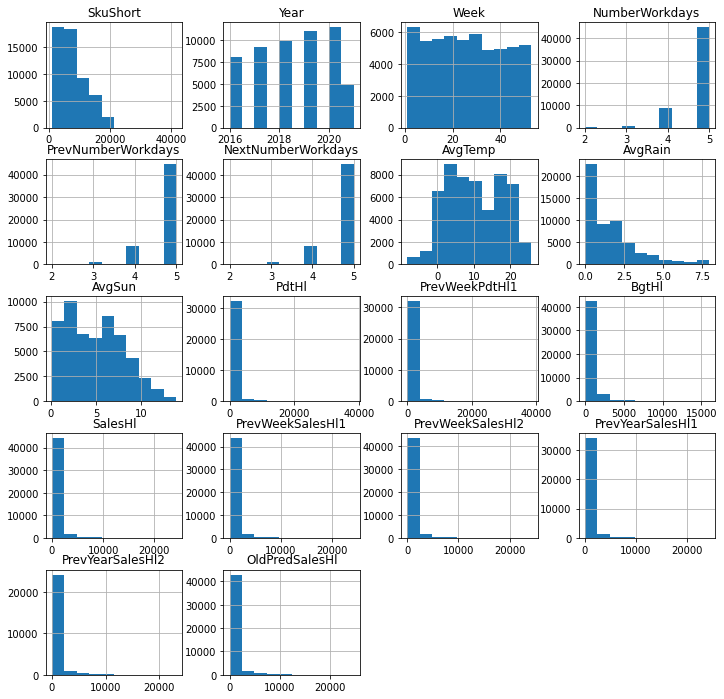

In [11]:
data.hist(figsize=[12,12])
plt.show()

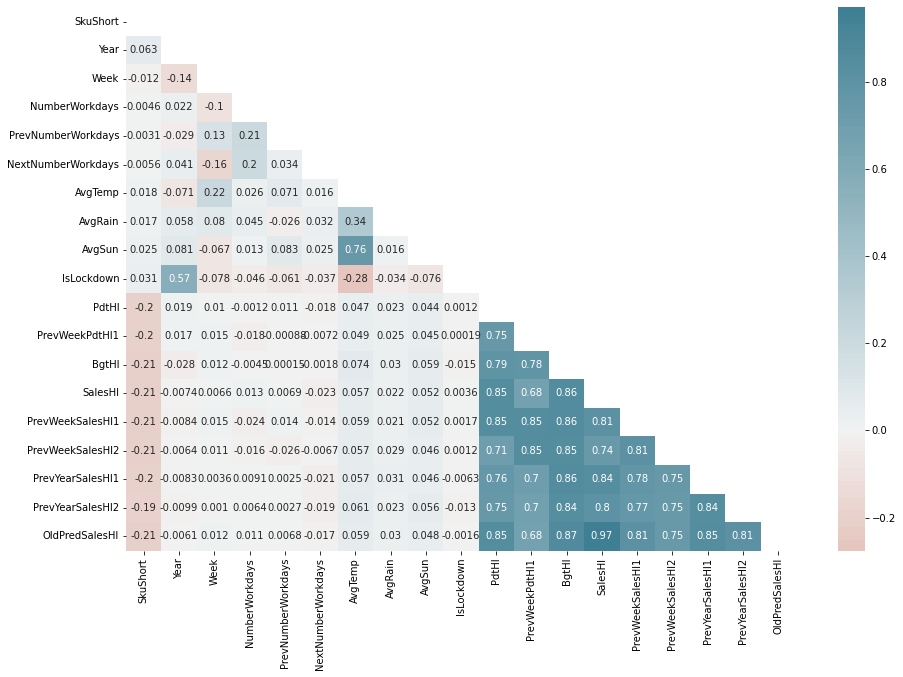

In [12]:
plt.subplots(figsize = (15,10))
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center = 0)
plt.show()

In [13]:
numData = data.select_dtypes(exclude='object')
numDatacorr = numData.corr()
salesHlFrame = numDatacorr['SalesHl'].sort_values(ascending=False).head(10).to_frame()

salesHlFrame.style.background_gradient(cmap=sns.light_palette("cyan", as_cmap=True))

,SalesHl
SalesHl,1.000000
OldPredSalesHl,0.971445
BgtHl,0.858415
PdtHl,0.847476
PrevYearSalesHl1,0.837645
PrevWeekSalesHl1,0.811917
PrevYearSalesHl2,0.803461
PrevWeekSalesHl2,0.738443
PrevWeekPdtHl1,0.678959
AvgTemp,0.056960


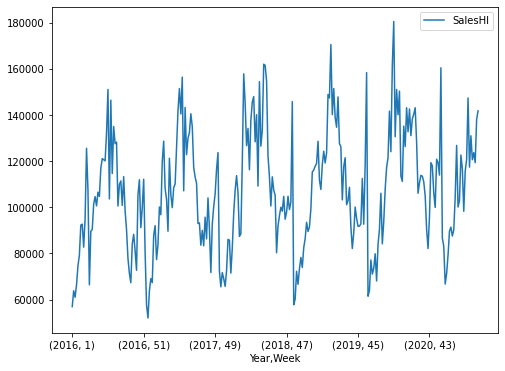

In [14]:
data.groupby(['Year','Week']).sum().plot(y=['SalesHl'], figsize=(8,6))
plt.show()

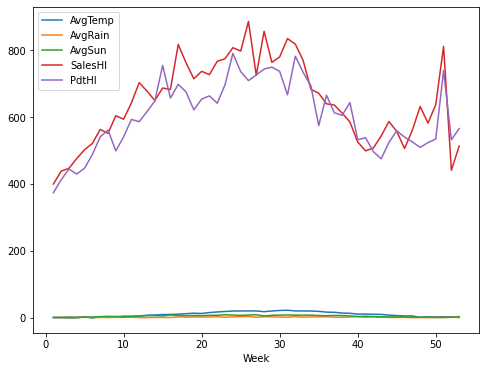

In [15]:
data.groupby(['Week']).mean().plot(y=['AvgTemp', 'AvgRain', 'AvgSun', 'SalesHl', 'PdtHl'], figsize=(8,6))
plt.show()

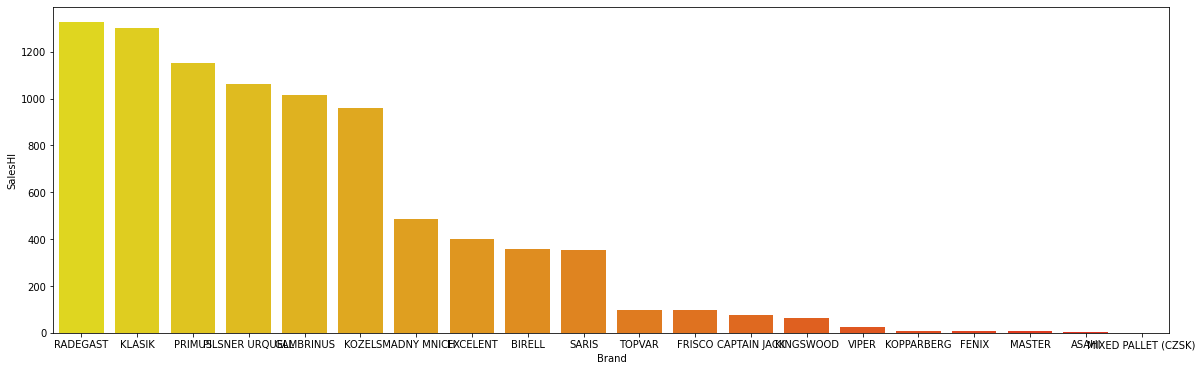

In [16]:
plt.figure(figsize=(20,6))
g_pps = data.groupby('Brand')['SalesHl'].mean().sort_values(ascending=False)
axis = sns.barplot(x=g_pps.index, y=g_pps, palette='autumn_r')
axis.set_xlabel('Brand')
axis.set_ylabel('SalesHl')

plt.show()

## Skewness and Kurtesis

In [17]:
data.skew()

SkuShort              0.789726
Year                 -0.062593
Week                  0.068405
NumberWorkdays       -2.682361
PrevNumberWorkdays   -2.626953
NextNumberWorkdays   -2.703510
AvgTemp               0.010925
AvgRain               1.576172
AvgSun                0.428223
IsLockdown            1.840740
PdtHl                NaN      
PrevWeekPdtHl1       NaN      
BgtHl                NaN      
SalesHl               5.380103
PrevWeekSalesHl1     NaN      
PrevWeekSalesHl2     NaN      
PrevYearSalesHl1     NaN      
PrevYearSalesHl2     NaN      
OldPredSalesHl       NaN      
dtype: float64

In [18]:
data.kurt()

SkuShort              0.581184 
Year                 -1.119692 
Week                 -1.190460 
NumberWorkdays        8.360695 
PrevNumberWorkdays    7.839844 
NextNumberWorkdays    8.471019 
AvgTemp               inf      
AvgRain               2.449219 
AvgSun               -0.619629 
IsLockdown            1.388374 
PdtHl                NaN       
PrevWeekPdtHl1       NaN       
BgtHl                NaN       
SalesHl               38.215713
PrevWeekSalesHl1     NaN       
PrevWeekSalesHl2     NaN       
PrevYearSalesHl1     NaN       
PrevYearSalesHl2     NaN       
OldPredSalesHl       NaN       
dtype: float64

In [19]:
# profile = ProfileReport(data, minimal=True)
# profile.to_notebook_iframe()

## Spliting data in X and Y

In [20]:
cols_drop = ['SalesHl', 'OldPredSalesHl'] #'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year', 'BgtHl', 'Brand', 'SubBrand'

X = data.drop(cols_drop, axis=1)
X_raw = X.copy(deep=True)
y = data.SalesHl.fillna(0).to_numpy()
y_oldPred = data.OldPredSalesHl.fillna(0).to_numpy()

## LabelEncoder

In [21]:
Country_mapping = {"CZ": 1, "SK": 2}
# PrimaryPack_mapping = {"CAN": 1, "KEG": 2, "RB": 3, "NRB": 4, "TANK": 5, "PET": 6, "KEG ONE WAY": 7, "KEG WOODEN": 8}
# ProductGroup_mapping = {"CLEAR BEER": 1, "FLAVOURED BEER": 2, "CIDER": 3, "SOFT DRINKS": 4, "MALT BASED BEV": 5, "WHEAT BEER": 6, "FABS - Seltzer sugar base": 7, "CLEAR BEER - MIXED PALLET (CZSK)": 8}

X.Country = X.Country.map(Country_mapping)
# X.PrimaryPack = X.PrimaryPack.map(PrimaryPack_mapping)
# X.ProductGroup =  X.ProductGroup.map(ProductGroup_mapping)

sku_encoder = LabelEncoder()
X.SkuShort = sku_encoder.fit_transform(X.SkuShort)

brand_encoder = LabelEncoder()
X.Brand = brand_encoder.fit_transform(X.Brand)
# X.SubBrand = LabelEncoder().fit_transform(X.SubBrand)

X.head()

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0,13,1,2016,1,5,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,1637.00000,NaN,NaN,NaN,NaN
1,0,13,2,2016,1,4,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,631.00000,NaN,NaN,NaN,NaN
2,1,13,1,2016,1,5,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,293.25000,NaN,NaN,NaN,NaN
3,1,13,2,2016,1,4,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,40.87500,NaN,NaN,NaN,NaN
4,2,13,1,2016,1,5,NaN,5,-1.164062,0.935547,1.014648,False,NaN,NaN,59.15625,NaN,NaN,NaN,NaN


## Imputer

In [22]:
X.BgtHl = X.BgtHl.fillna(0)
X.PdtHl = X.PdtHl.fillna(0)
X.PrevWeekPdtHl1 = X.PrevWeekPdtHl1.fillna(0)
X.PrevNumberWorkdays = X.PrevNumberWorkdays.fillna(5)
X.NextNumberWorkdays = X.NextNumberWorkdays.fillna(5)

In [23]:
X.BgtHl = X.BgtHl.apply(lambda x : x if x > 0 else 0)

In [24]:
# imputer = SimpleImputer(strategy='mean')
imputer = SimpleImputer(strategy='constant', fill_value=0)
# imputer = IterativeImputer(random_state=0, skip_complete=True, min_value=0)
# imputer = KNNImputer()

X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekSalesHl1,PrevWeekSalesHl2,PrevYearSalesHl1,PrevYearSalesHl2
0,0.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,1637.000000,0.000000,0.000000,0.000000,0.0000
1,0.0,13.0,2.0,2016.0,1.0,4.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,631.000000,0.000000,0.000000,0.000000,0.0000
2,1.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,293.250000,0.000000,0.000000,0.000000,0.0000
3,1.0,13.0,2.0,2016.0,1.0,4.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,40.875000,0.000000,0.000000,0.000000,0.0000
4,2.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,59.156250,0.000000,0.000000,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54647,283.0,19.0,1.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,0.000000,0.000000,0.000000,23.484375,27.359375,0.000000,0.0000
54648,285.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,60.875000,46.593750,178.625000,216.500000,55.437500,90.937500,331.0000
54649,288.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,1.320312,1.320312,1.307617,0.000000,0.000000,16.796875,66.9375
54650,291.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,34.656250,27.500000,105.437500,137.125000,16.921875,37.906250,353.7500


## Adding a new feature

In [25]:
# X['AvgPrevWeekSalesHl'] = X[['PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)
X['AvgPrevYearSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2']].mean(axis=1).round(1)
X['AvgPrevAllSalesHl'] = X[['PrevYearSalesHl1', 'PrevYearSalesHl2', 'PrevWeekSalesHl1', 'PrevWeekSalesHl2']].mean(axis=1).round(1)

X = X.drop(['PrevWeekSalesHl1', 'PrevWeekSalesHl2'], axis=1)

X

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,0.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,1637.000000,0.000000,0.0000,0.0,0.0
1,0.0,13.0,2.0,2016.0,1.0,4.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,631.000000,0.000000,0.0000,0.0,0.0
2,1.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,293.250000,0.000000,0.0000,0.0,0.0
3,1.0,13.0,2.0,2016.0,1.0,4.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,40.875000,0.000000,0.0000,0.0,0.0
4,2.0,13.0,1.0,2016.0,1.0,5.0,5.0,5.0,-1.164062,0.935547,1.014648,0.0,0.000000,0.000000,59.156250,0.000000,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54647,283.0,19.0,1.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,12.7
54648,285.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,60.875000,46.593750,178.625000,90.937500,331.0000,211.0,173.5
54649,288.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,1.320312,1.320312,1.307617,16.796875,66.9375,41.9,20.9
54650,291.0,17.0,2.0,2021.0,24.0,5.0,5.0,5.0,22.296875,0.065918,13.250000,0.0,34.656250,27.500000,105.437500,37.906250,353.7500,195.8,136.4


## Split train and test

In [26]:
train_index = len(X[(X.Year <= TRAIN_TO_YEAR-1) | ((X.Year == TRAIN_TO_YEAR) & (X.Week < TRAIN_TO_WEEK))])
# train_index = len(X[(X.Year <= 2019) | ((X.Year == 2020) & (X.Week < 45))])

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 21)
 
X_train = X.iloc[:train_index]
y_train = y[:train_index]

X_test = X.iloc[train_index:]
X_test_raw = X_raw.iloc[train_index:]
y_test = y[train_index:]
y_test_oldPred = y_oldPred[train_index:]

## Scaler

In [27]:
# scaler = MinMaxScaler()
# scaler = MaxAbsScaler()
scaler = StandardScaler()
# scaler = RobustScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train

,SkuShort,Brand,Country,Year,Week,NumberWorkdays,PrevNumberWorkdays,NextNumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevYearSalesHl1,PrevYearSalesHl2,AvgPrevYearSalesHl,AvgPrevAllSalesHl
0,-1.637458,0.860730,-0.826255,-1.549257,-1.662408,0.439325,0.432558,0.436344,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,0.865712,-0.330814,-0.279547,-0.330606,-0.397362
1,-1.637458,0.860730,1.210280,-1.549257,-1.662408,-1.536864,0.432558,0.436344,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,0.079550,-0.330814,-0.279547,-0.330606,-0.397362
2,-1.625366,0.860730,-0.826255,-1.549257,-1.662408,0.439325,0.432558,0.436344,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,-0.184393,-0.330814,-0.279547,-0.330606,-0.397362
3,-1.625366,0.860730,1.210280,-1.549257,-1.662408,-1.536864,0.432558,0.436344,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,-0.381617,-0.330814,-0.279547,-0.330606,-0.397362
4,-1.613275,0.860730,-0.826255,-1.549257,-1.662408,0.439325,0.432558,0.436344,-1.481516,-0.435334,-1.280601,-0.409662,-0.295589,-0.292932,-0.367331,-0.330814,-0.279547,-0.330606,-0.397362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52512,1.820693,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.532380,0.436344,-0.710955,-0.541530,0.324814,2.441036,0.216085,-0.292932,-0.218582,-0.330814,-0.279547,-0.330606,-0.266739
52513,1.844876,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.532380,0.436344,-0.710955,-0.541530,0.324814,2.441036,-0.294520,-0.291818,-0.411225,-0.319593,-0.251595,-0.310086,-0.387320
52514,1.856967,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.532380,0.436344,-0.710955,-0.541530,0.324814,2.441036,-0.086912,-0.292932,-0.413560,-0.330814,-0.279547,-0.330606,-0.343581
52515,1.881150,1.587121,1.210280,1.789150,-0.809477,-1.536864,-1.532380,0.436344,-0.710955,-0.541530,0.324814,2.441036,-0.294395,-0.291246,-0.348063,-0.289567,-0.207801,-0.270698,-0.356771


## Find best params

In [28]:
# # model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS) #0.6967554482801138

# # model = ensemble.RandomForestRegressor(random_state=0, criterion='mse', min_samples_split=2, min_samples_leaf=3, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, oob_score=True, n_jobs=MAX_N_JOBS) #0.7286310878145617 

# model = linear_model.LinearRegression(copy_X=True, fit_intercept=True, normalize=False, positive=False)

# param_grid = dict() #importance_type=['gain', 'weight', 'cover','total_gain','total_cover']
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train)
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)

In [29]:
# model = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS)#0.9168

# # Train the model using the training sets
# model.fit(X_train, y_train)

# # Make predictions using the testing set
# y_pred = model.predict(X_test)
# y_pred[y_pred < 0] = 0
# y_pred = y_pred.round(0)

# print(DATASET_NAME)
# print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
# print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
# print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
# print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
# print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

## Models

### HistGradientBoostingRegressor 

In [30]:
hgbModel = ensemble.HistGradientBoostingRegressor(random_state=0, loss='least_squares', learning_rate=0.05, max_iter=250, max_leaf_nodes=150, min_samples_leaf=25, early_stopping=False)

### MLPRegressor

In [31]:
mlpModel = neural_network.MLPRegressor(random_state=0, activation='relu', solver='adam', hidden_layer_sizes=100, shuffle=False, warm_start=True, max_iter=1000, early_stopping=False)

### RandomForestRegressor

In [32]:
rfModel = ensemble.RandomForestRegressor(random_state=0, criterion='mse', min_samples_split=2, min_samples_leaf=3, n_estimators=100, max_depth=None, max_features=None, bootstrap=True, oob_score=True, n_jobs=MAX_N_JOBS)

### XGBRegressor

In [33]:
xgbModel = xgboost.XGBRegressor(random_state=0, tree_method='approx', booster='dart', importance_type='gain',  reg_lambda=10, reg_alpha=23, colsample_bytree= 0.5, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=100,n_jobs=MAX_N_JOBS)

### CatBoostRegressor

In [34]:
cbModel = catboost.CatBoostRegressor(learning_rate=0.05, eval_metric='RMSE', loss_function='RMSE', bootstrap_type='No', leaf_estimation_method='Newton', random_seed=42, verbose=0)

### LGBMRegressor

In [35]:
lgbmModel = lightgbm.LGBMRegressor(random_state=0, boosting_type='goss', learning_rate=0.2, num_leaves=35, n_estimators=50, n_jobs=MAX_N_JOBS)

### ExtraTreesRegressor

In [36]:
etrModel = ensemble.ExtraTreesRegressor(bootstrap=True, criterion='mse', max_features='auto', oob_score=True, warm_start=True, n_estimators=200, min_weight_fraction_leaf=0, min_samples_split=2 , min_samples_leaf=2, ccp_alpha=0.7)

### Use models

In [37]:
regression_models = [lgbmModel, cbModel, hgbModel, rfModel, etrModel]

if (DATASET_MARKET == 'on-trade'):
    regression_models = [hgbModel, lgbmModel, cbModel, rfModel, etrModel]

if (DATASET_MARKET == 'off-trade'):
    regression_models = [rfModel, etrModel, hgbModel, cbModel, lgbmModel]


regression_models

[RandomForestRegressor(criterion='mse', max_features=None, min_samples_leaf=3,
                       n_jobs=8, oob_score=True, random_state=0),
 ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.7, criterion='mse',
                     max_features='auto', min_samples_leaf=2,
                     min_weight_fraction_leaf=0, n_estimators=200,
                     oob_score=True, warm_start=True),
 HistGradientBoostingRegressor(early_stopping=False, learning_rate=0.05,
                               loss='least_squares', max_iter=250,
                               max_leaf_nodes=150, min_samples_leaf=25,
                               random_state=0),
 LGBMRegressor(boosting_type='goss', learning_rate=0.2, n_estimators=50,
               n_jobs=8, num_leaves=35, random_state=0)]

In [38]:
estimators = []
result_models = pd.DataFrame(columns=['Model', 'Score', "AbsoluteScore", 'ME', 'MSE', 'MAE'])

for reg_model in regression_models:
    
    reg_model.fit(X_train, y_train)
    y_pred = reg_model.predict(X_test)
    
    model_name = type(reg_model).__name__
    score = r2_score(y_test, y_pred)
    abs_score = absolute_score(y_test, y_pred)
    me = max_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    result_models.loc[len(result_models.index)] = [model_name, score, abs_score, me, mse, mae]

    estimators.append((model_name, reg_model))

In [39]:
col_metric = 'MAE'
min_metric = result_models[col_metric].min()
max_metric = result_models[col_metric].max()
min_weight = max_metric - ((min_metric - max_metric) * 0.2)

result_models["Weights"] = result_models[col_metric].map(lambda x: round((x - min_weight) / (min_metric - min_weight), 2))
result_models.sort_values(by=["Weights"], ascending=False)

,Model,Score,AbsoluteScore,ME,MSE,MAE,Weights
0,RandomForestRegressor,0.846688,0.606712,6209.133549,343852.944845,235.027662,1.00
3,CatBoostRegressor,0.850316,0.606495,6433.113142,335715.940876,235.157634,0.93
1,ExtraTreesRegressor,0.849011,0.605983,5582.732301,338641.831957,235.463497,0.76
4,LGBMRegressor,0.845982,0.605695,6482.768898,345436.576019,235.635294,0.67
2,HistGradientBoostingRegressor,0.836423,0.604141,6536.375078,366875.354183,236.564366,0.17


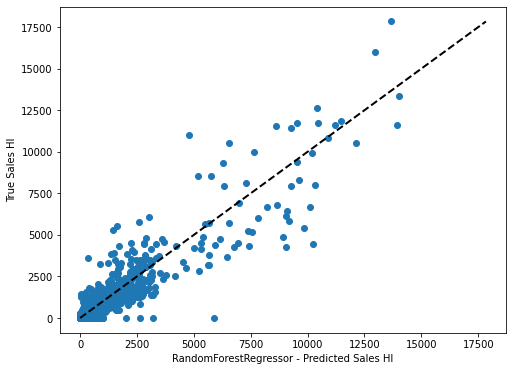

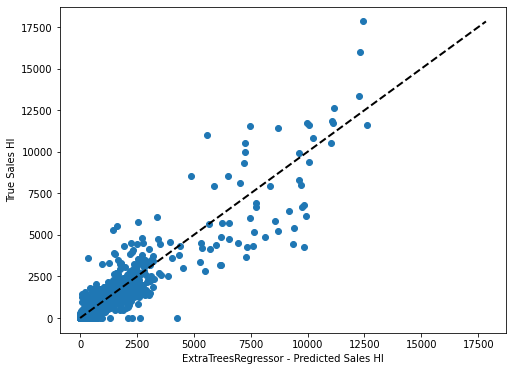

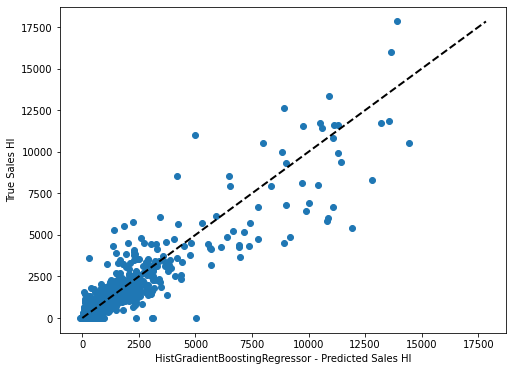

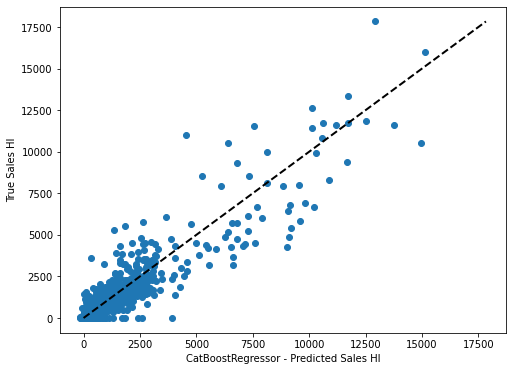

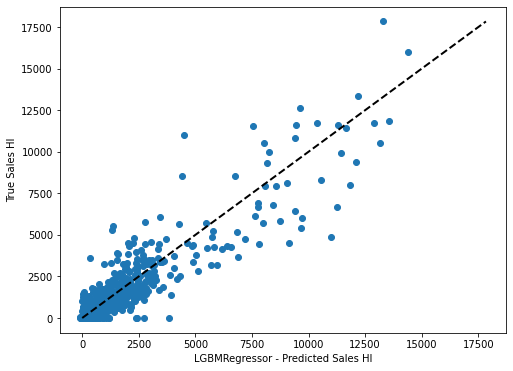

In [40]:
for key, model in estimators:
    y_pred = model.predict(X_test)
    show_pred(y_test, y_pred, f"{key} - Predicted Sales Hl", "True Sales Hl")

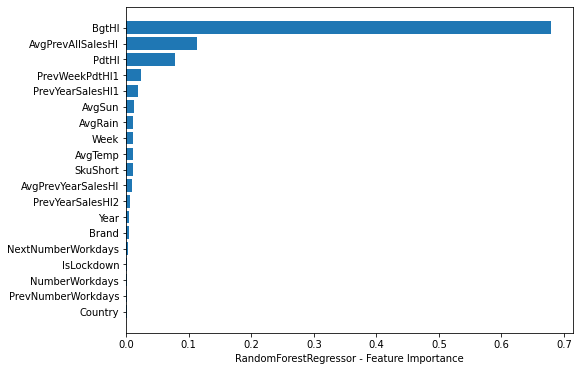

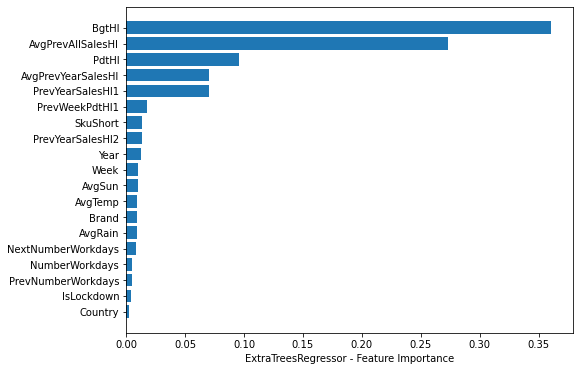

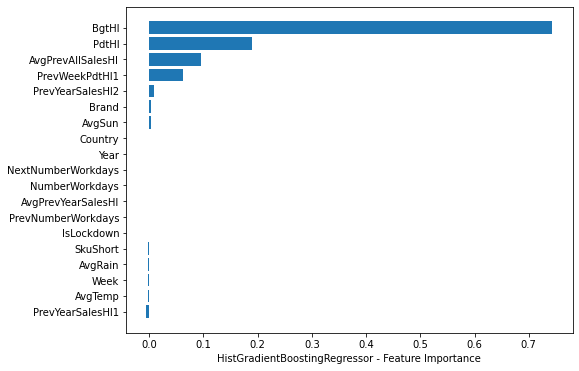

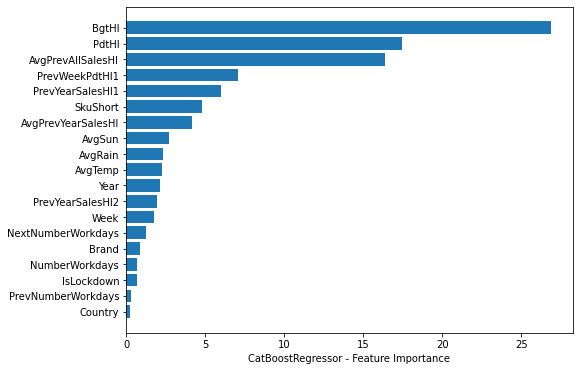

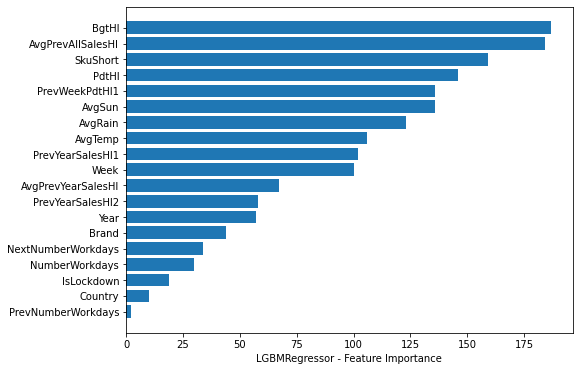

In [41]:
for key, model in estimators:
    show_feature_importances(model, X_test, y_test)

### VotingRegressor

In [42]:
model = ensemble.VotingRegressor(estimators=estimators, weights=result_models.Weights.values, n_jobs=1)

model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0
y_pred = y_pred.round(0)

In [43]:
print(DATASET_NAME)
print('----------------')
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))
print('Absolute Score: %.4f'% absolute_score(y_test, y_pred))
print('Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_pred))
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))
print('Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_pred))

print('----------------')

print('Classic Coefficient of determination: %.4f'% r2_score(y_test, y_test_oldPred))
print('Classic Absolute Score: %.4f'% absolute_score(y_test, y_test_oldPred))
print('Classic Mean absolute error regression loss.: %.4f'% mean_absolute_error(y_test, y_test_oldPred))
print('Classic Maximum residual error: %.4f'% max_error(y_test, y_test_oldPred))
print('Classic Mean squared error regression loss: %.4f'% mean_squared_error(y_test, y_test_oldPred))


off-trade_all
----------------
Coefficient of determination: 0.8564
Absolute Score: 0.6151
Mean absolute error regression loss.: 230.0441
Maximum residual error: 6125.5000
Mean squared error regression loss: 321971.6274
----------------
Classic Coefficient of determination: 0.9491
Classic Absolute Score: 0.7866
Classic Mean absolute error regression loss.: 127.5466
Classic Maximum residual error: 4628.0000
Classic Mean squared error regression loss: 114129.1688


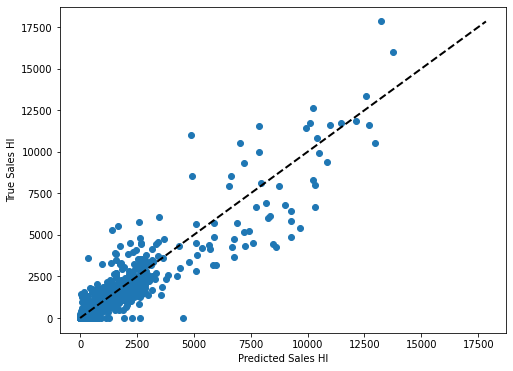

In [44]:
show_pred(y_test, y_pred, "Predicted Sales Hl", "True Sales Hl")

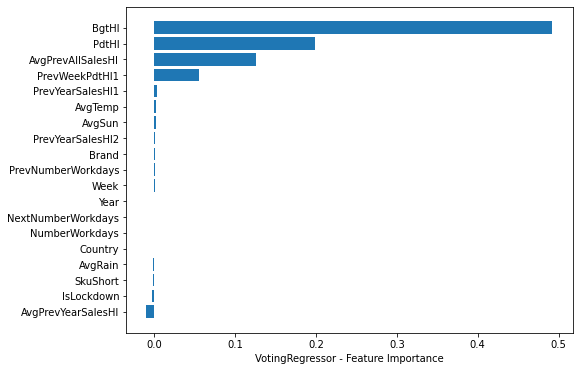

In [45]:
show_feature_importances(model, X_test, y_test)

## Save Result

In [46]:
result = X_test_raw.copy(deep=True)
result["TrueSalesHl"] = y_test
result["PredSalesHl_Classic"] = y_test_oldPred
result["PredSalesHl_ML"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [47]:
dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
joblib.dump(imputer, IMPUTER_PATH)
joblib.dump(sku_encoder, SKU_ENCODER_PATH)
joblib.dump(brand_encoder, BRAND_ENCODER_PATH)

['./models/off-trade_all_brand_encoder.joblib']